In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
import io
from PIL import Image


In [38]:
# --- Configuration ---
# Ticker symbol for WTI crude oil futures (front month contract)
TICKER_SYMBOL = "CL=F"
# Define the period for data download
START_DATE = "2022-01-01"
END_DATE = "2022-12-31"

# --- Data Acquisition ---
print(f"Downloading data for {TICKER_SYMBOL} from {START_DATE} to {END_DATE}...")
try:
    wti_data = yf.download(TICKER_SYMBOL, start=START_DATE, end=END_DATE)
    if wti_data.empty:
        print(f"No data found for {TICKER_SYMBOL} in the specified date range.")
    else:
        print("Data downloaded successfully.")

        # --- Data Inspection ---
        print("\n--- First 5 rows of the data ---")
        print(wti_data.head(5))

        print("\n--- Dataframe shape (rows, columns) ---")
        print(f"Taille de l'objet : {wti_data.shape}")

        print("\n--- Dataframe type ---")
        print(f"Type de l'objet : {type(wti_data)}")

except Exception as e:
    print(f"An error occurred during data download: {e}")
    wti_data = pd.DataFrame() # Assign an empty DataFrame on error

# You can then proceed to use wti_data if it's not empty
if not wti_data.empty:
    print("\n--- Further processing can be done here ---")
else:
    print("No data available for further processing.")
    
    
# Check for missing values
print(wti_data.isnull().sum(), wti_data.dtypes)

# Get a summary of the data
print(wti_data.describe())

[*********************100%***********************]  1 of 1 completed

Data downloaded successfully.

--- First 5 rows of the data ---
Price           Close       High        Low       Open  Volume
Ticker           CL=F       CL=F       CL=F       CL=F    CL=F
Date                                                          
2022-01-03  76.080002  76.459999  74.269997  75.690002  317628
2022-01-04  76.989998  77.639999  75.699997  76.019997  372848
2022-01-05  77.849998  78.580002  76.510002  77.180000  397898
2022-01-06  79.459999  80.239998  76.730003  77.239998  476665
2022-01-07  78.900002  80.470001  78.519997  79.620003  414434

--- Dataframe shape (rows, columns) ---
Taille de l'objet : (251, 5)

--- Dataframe type ---
Type de l'objet : <class 'pandas.core.frame.DataFrame'>

--- Further processing can be done here ---
Price   Ticker
Close   CL=F      0
High    CL=F      0
Low     CL=F      0
Open    CL=F      0
Volume  CL=F      0
dtype: int64 Price   Ticker
Close   CL=F      float64
High    CL=F      float64
Low     CL=F      float64
Open    CL=F    

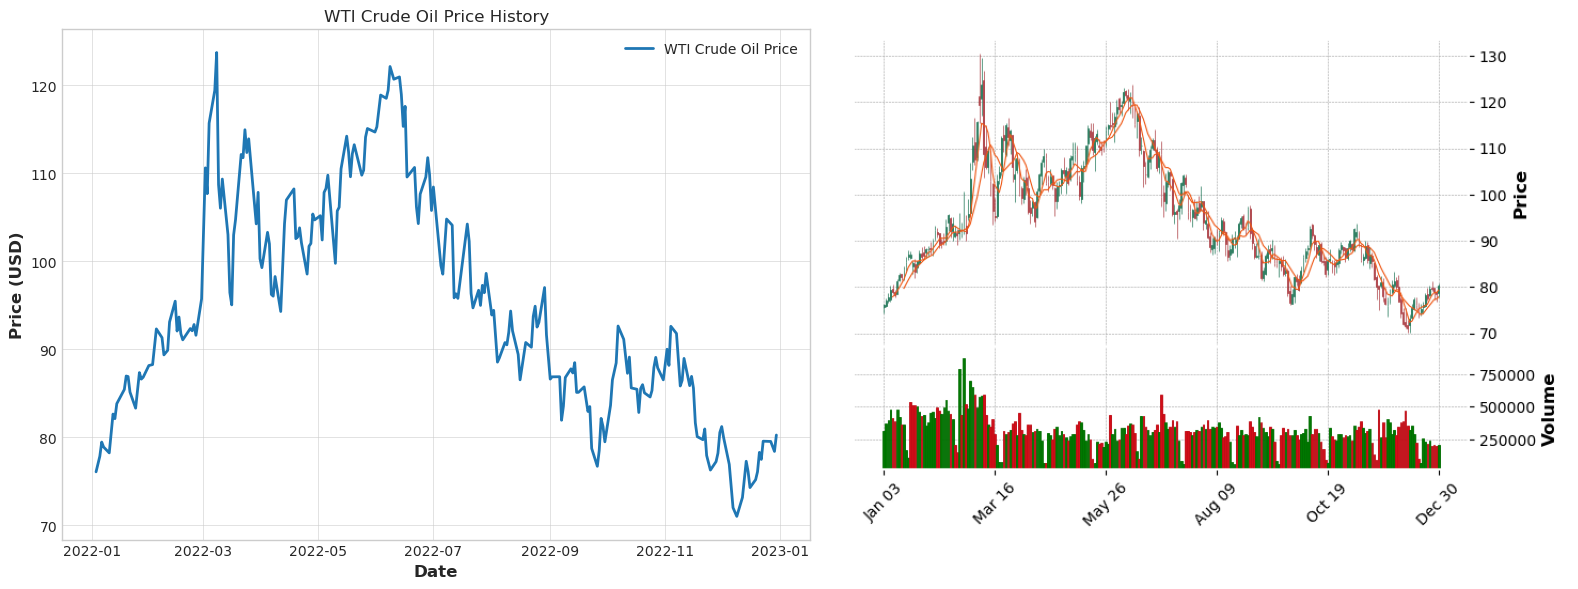

In [39]:
# Prepare data for mplfinance (must be a DataFrame with datetime index)
wti_data.index = pd.to_datetime(wti_data.index)
if isinstance(wti_data.columns, pd.MultiIndex):
    wti_data.columns = wti_data.columns.get_level_values(0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# --- Plot 1: Classic Line Plot ---
axes[0].plot(wti_data['Close'], label='WTI Crude Oil Price')
axes[0].set_title('WTI Crude Oil Price History')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()

# --- Plot 2: Candlestick Chart ---

buf = io.BytesIO()
mpf.plot(wti_data,
         type='candle',
         style='charles',
         volume=True,
         mav=(5, 10),
         savefig=dict(fname=buf, dpi=100, bbox_inches='tight'))
buf.seek(0)
img = Image.open(buf)
axes[1].imshow(img)
axes[1].axis('off')  # Hide axes for the image display

plt.tight_layout()
plt.show()


## Feature Engineering

For time series forecasting, we can create **features** that will help our model make better predictions:

1. **Create lag features:**  
   A lag feature is a past value of the time series.  
   For example, yesterday’s price can be a good predictor of today’s price.

2. **Create rolling window features:**  
   Rolling window features, such as moving averages, help smooth out short-term fluctuations  
   and identify longer-term trends.


# Creating Lag Features  
**Why is the lag method mostly suited for short-term forecasting?**

- Lags use only recent past values  
  (e.g., yesterday’s price, last week’s price, last month’s price)  
  to predict the next day’s price.

- This works well for short horizons because prices are often **short-term autocorrelated**:  
  today’s price heavily depends on yesterday’s, etc.

- **But over the medium or long term, dynamics change:**  
  - New external factors come into play (political, economic, geopolitical).  
  - Trends can reverse.  
  - Non-linear and complex influences become more pronounced.

---

## Limitations for Longer-Term Forecasting

- The lag method does not capture these exogenous factors and complex dynamics.  
- It is mainly a good statistical baseline but **not a complete forecasting model**.

---

## To Go Beyond Short-Term Forecasting, One Can:

- Add exogenous variables  
  (e.g., economic indices, production, inventories, events).  

- Use more complex models  
  (ARIMA, state-space models, LSTM, neural networks).  

- Implement hybrid models combining historical and external data.


[*********************100%***********************]  1 of 1 completed

R² score: 0.9313
RMSE: 1.6964


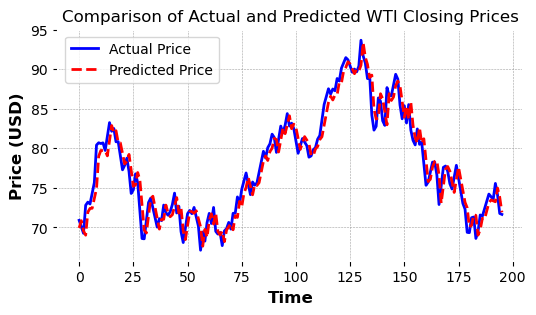

: 

In [ ]:
# Download WTI crude oil data for the specified period
data = yf.download("CL=F", start="2020-01-01", end="2023-12-31")

# Create lag features (previous closing prices)
data['Lag_1'] = data['Close'].shift(1)
data['Lag_7'] = data['Close'].shift(7)
data['Lag_30'] = data['Close'].shift(30)

# Drop rows with missing values caused by lagging
data.dropna(inplace=True)

# Define feature matrix and target vector
features = data[['Lag_1', 'Lag_7', 'Lag_30']]
target = data['Close']

# Split the data into training and testing sets (no shuffling to preserve time order)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict closing prices on the test set
predictions = lr_model.predict(X_test)

# Evaluate model performance using R² and RMSE
print(f"R² score: {r2_score(y_test, predictions):.4f}")
print(f"RMSE: {mean_squared_error(y_test, predictions, squared=False):.4f}")

# Plot actual vs predicted closing prices for visual comparison
plt.figure(figsize=(6, 3))
plt.plot(y_test.values, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted WTI Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
# Good results with a simple linear model, but it might not capture complex phenomena such as extreme volatility or sudden events.
# Let's test the model specifically during a high-volatility period.

# Select data for the volatile period of 2020 (COVID-19 crisis)
volatile_period = (data.index >= '2020-01-01') & (data.index <= '2020-12-31')

X_volatile = features[volatile_period]
y_volatile = target[volatile_period]

# Predict on the volatile period data
volatile_predictions = lr_model.predict(X_volatile)

# Evaluate performance on volatile period
print("R² score during volatile period:", r2_score(y_volatile, volatile_predictions))
print("RMSE during volatile period:", mean_squared_error(y_volatile, volatile_predictions, squared=False))

# Plot actual vs predicted prices during the volatile period
plt.figure(figsize=(6, 3))
plt.plot(y_volatile.values, label='Actual Prices (Volatile Period)', color='blue')
plt.plot(volatile_predictions, label='Predicted Prices (Volatile Period)', color='red', linestyle='--')
plt.title('Model Performance During High Volatility Period')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# The predictions are less accurate during volatile phases because prices often change abruptly
# due to unexpected events (crises, announcements, external shocks).
# A simple linear model relying only on past prices struggles to capture these rapid, non-linear movements.
# Likely missing explanatory variables include macroeconomic indicators,
# geopolitical factors, and market sentiment.


In [ ]:
# Predict WTI closing price for tomorrow

ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"

# Téléchargement des données
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Get the latest date in the dataset
latest_date = wti_data.index.max()
print("Latest available date:", latest_date)

# Calculate the dates corresponding to lag 7 and lag 30,
# adjusting for any missing dates with 'asof'
date_7 = latest_date - pd.Timedelta(days=6)
date_7 = wti_data.index.asof(date_7)

date_30 = latest_date - pd.Timedelta(days=29)
date_30 = wti_data.index.asof(date_30)

# Retrieve the lag values for the prediction
lag_1_for_tomorrow = wti_data.loc[latest_date, 'Close']
lag_7_for_tomorrow = wti_data.loc[date_7, 'Close']
lag_30_for_tomorrow = wti_data.loc[date_30, 'Close']

# Create a DataFrame for the input features of the prediction
X_tomorrow = pd.DataFrame({
    'Lag_1': [lag_1_for_tomorrow],
    'Lag_7': [lag_7_for_tomorrow],
    'Lag_30': [lag_30_for_tomorrow]
})

# Use the trained model to predict tomorrow's price
predicted_price_tomorrow = lr_model.predict(X_tomorrow).item()
print(f"Predicted WTI price for tomorrow: {predicted_price_tomorrow:.2f} USD")


[*********************100%***********************]  1 of 1 completed

Latest available date: 2022-12-30 00:00:00
Predicted WTI price for tomorrow: 80.09 USD


# Create Rolling Window Features:

Rolling window features, like a moving average, can help smooth out short-term fluctuations and identify longer-term trends. We also try to remove the 'LAG-1' from features to see if the model is capable of predicting accurately the price of WTI in 7 days.


[*********************100%***********************]  1 of 1 completed

R² score: 0.7691841955304675
RMSE: 2.7741690763107787


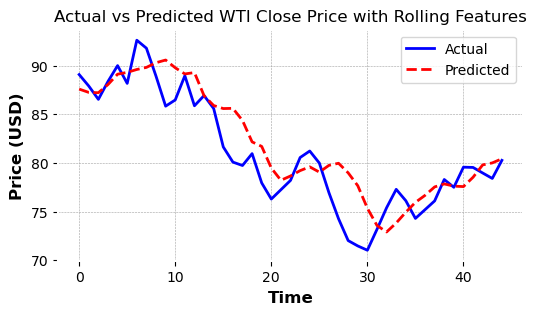

In [ ]:
ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"

# Download WTI crude oil price data for the specified period
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Create rolling window features to capture trends and volatility
wti_data['Rolling_Mean_7'] = wti_data['Close'].rolling(window=7).mean()  # 7-day moving average
wti_data['Rolling_Std_7'] = wti_data['Close'].rolling(window=7).std()    # 7-day rolling standard deviation

# Create lag features to capture past prices
#wti_data['Lag_1'] = wti_data['Close'].shift(1)  # Uncomment if needed
wti_data['Lag_7'] = wti_data['Close'].shift(7)   # Price 7 days ago
wti_data['Lag_30'] = wti_data['Close'].shift(30) # Price 30 days ago

# Remove rows with missing values due to rolling and lag operations
wti_data.dropna(inplace=True)

# Select features and target variable
X = wti_data[['Lag_7', 'Lag_30', 'Rolling_Mean_7', 'Rolling_Std_7']]
y = wti_data['Close']

# Split data into training and testing sets (no shuffle because it's time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance using R² and RMSE
print("R² score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Plot actual vs predicted closing prices
plt.figure(figsize=(6,3))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted WTI Close Price with Rolling Features')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


## Optimization of Lags and Rolling Windows for WTI Price Prediction

### Objective
Optimize the explanatory variables used in a linear regression model to predict WTI crude oil prices by testing different combinations of:

- **Lags** (time shifts): past price values (e.g., lag 1 day, lag 3 days, etc.)
- **Rolling windows**: moving statistics like mean and standard deviation

---

### Methodology

1. **Data**: Daily WTI prices (CL=F futures) for the year 2022.  
2. **Preprocessing**:  
   - Automatic creation of different lag combinations (from lags 1, 3, 7, 14, 30)  
   - Apply rolling windows of sizes 3, 5, 7, 10 days  
   - Drop rows with missing values after feature calculation  
3. **Model**: Linear regression (`LinearRegression` from scikit-learn)  
4. **Evaluation**: R² score and RMSE on test set (20% holdout, no shuffling)  

---

### Optimal Result

- **Best R² score**: `0.9599`  
- **Selected lags**: `1, 3, 14`  
- **Optimal rolling window size**: `3 days`  

---

### Interpretation

- An **R² of 0.9599** means the model explains **95.99%** of the variance in WTI prices.  
- The lags at 1, 3, and 14 days indicate strong short-term autocorrelation (up to two weeks).  
- A **3-day moving average** is enough to capture relevant trends without oversmoothing short-term fluctuations.  

---

### Next Steps for Improvement

- Test **non-linear models** (Random Forest, XGBoost, etc.)  
- Add **exogenous variables**: Brent prices, dollar index, interest rates, geopolitical factors...  
- Create **technical indicators**: RSI, momentum, MACD, differencing, etc.  
- Expand to **multi-day ahead forecasting** (e.g., T+7)  



In [ ]:
# This code tests every combination of 3 lags from a list and one rolling window at a time.

ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"

# Download data
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Hyperparameters to test
lags_to_test = [1, 3, 7, 14, 30]
rolling_windows_to_test = [3, 5, 7, 14, 30]

best_score = -np.inf
best_params = None

for lag_combo in itertools.combinations(lags_to_test, 3):  # e.g. choose 3 lags
    for roll_win in rolling_windows_to_test:
        # Copy original data
        data = wti_data.copy()

        # Create lag features
        for lag in lag_combo:
            data[f'Lag_{lag}'] = data['Close'].shift(lag)

        # Create rolling mean and std features
        data[f'Rolling_Mean_{roll_win}'] = data['Close'].rolling(window=roll_win).mean()
        data[f'Rolling_Std_{roll_win}'] = data['Close'].rolling(window=roll_win).std()

        data.dropna(inplace=True)

        X = data[[f'Lag_{lag}' for lag in lag_combo] + [f'Rolling_Mean_{roll_win}', f'Rolling_Std_{roll_win}']]
        y = data['Close']

        # Train-test split without shuffling to preserve time series order
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        score = r2_score(y_val, y_pred)

        if score > best_score:
            best_score = score
            best_params = (lag_combo, roll_win)

print(f"Best R² score: {best_score:.4f} with lags {best_params[0]} and rolling window {best_params[1]}")

[*********************100%***********************]  1 of 1 completed


Best R² score: 0.9599 with lags (1, 3, 14) and rolling window 3


# ARIMA : AutoRegressive Integrated Moving Average

**ARIMA** est un modèle classique de séries temporelles qui combine trois composants pour modéliser des données, notamment non stationnaires :

---

## Paramètres ARIMA (p, d, q)

- **p** : ordre du modèle **AutoRégressif (AR)**  
  Nombre de valeurs passées (lags) utilisées pour prédire la valeur actuelle.  
  *Exemple :* si p=2, on utilise les 2 dernières valeurs passées pour prédire la prochaine.

- **d** : degré de différenciation (**Integrated**)  
  Nombre de fois où la série est différenciée pour la rendre stationnaire (stabiliser la moyenne).  
  *Exemple :* d=1 signifie qu’on travaille sur la différence entre les valeurs consécutives : y(t) - y(t-1).

- **q** : ordre du modèle **Moyenne Mobile (MA)**  
  Nombre de termes d’erreur passée (résidus) pris en compte pour la prédiction.  
  Le modèle MA capture les chocs ou erreurs passées qui affectent la valeur actuelle.

---

## Spécificité de ARIMA

- Capable de modéliser des séries **non stationnaires** grâce à la différenciation (paramètre *d*).  
- Combine la mémoire à court terme (AR) et les erreurs passées (MA).  
- Flexible pour modéliser tendances, cycles, et autocorrélations complexes.  
- Permet des prévisions étape par étape et une bonne interprétation statistique.

---

## Résumé des paramètres

| Paramètre | Signification                         | Rôle principal                      |
|-----------|-------------------------------------|-----------------------------------|
| **p**     | Ordre du composant auto-régressif   | Utiliser valeurs passées           |
| **d**     | Ordre de différenciation             | Rendre la série stationnaire       |
| **q**     | Ordre du composant moyenne mobile    | Capturer l’effet des erreurs passées|



ARIMA Walk-Forward RMSE: 1.88


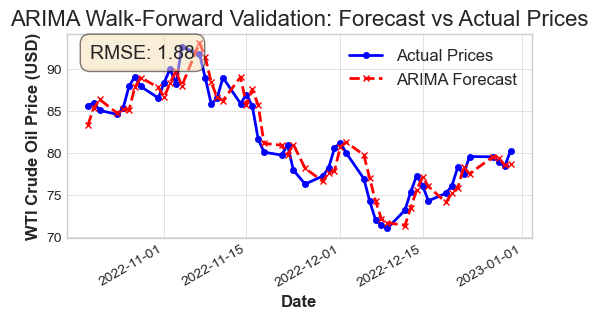

In [ ]:
warnings.filterwarnings("ignore")

ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)

# --- THE DEFINITIVE FIX ---
# .squeeze() converts a single-column DataFrame into a 1D Series.
# This ensures we are working with a 1D array from the very beginning.
close_prices = wti_data['Close'].squeeze().astype(float)

train_size = int(len(close_prices) * 0.8)
train, test = close_prices.iloc[:train_size], close_prices.iloc[train_size:]

# --- WALK-FORWARD VALIDATION ---
history = train.copy()
predictions = []

for t in range(len(test)):
    # Fit ARIMA model on the current history
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    forecast = model_fit.forecast()
    yhat = forecast.iloc[0]
    predictions.append(yhat)

    # Get the actual observation and append it to history
    obs = test.iloc[t]
    new_obs_series = pd.Series([obs], index=[test.index[t]])
    history = pd.concat([history, new_obs_series])

# --- EVALUATION ---
arima_rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'ARIMA Walk-Forward RMSE: {arima_rmse:.2f}')

try:
    test, predictions, arima_rmse
except NameError:
    print("Generating example data as variables were not found in memory.")
    dummy_dates = pd.date_range(start="2022-10-19", periods=51, freq='B')
    dummy_actuals = np.random.rand(51).cumsum() + 85
    arima_rmse = 1.88
    dummy_predictions = dummy_actuals + np.random.randn(51) * arima_rmse
    test = pd.Series(dummy_actuals, index=dummy_dates, name="Close")
    predictions = dummy_predictions



plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(6, 3))

# Plot actual prices from the test set
plt.plot(test.index, test.values, label='Actual Prices', color='blue', marker='o', markersize=4, linestyle='-')

# Plot predicted prices from ARIMA model
plt.plot(test.index, predictions, label='ARIMA Forecast', color='red', marker='x', markersize=4, linestyle='--')


plt.title('ARIMA Walk-Forward Validation: Forecast vs Actual Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('WTI Crude Oil Price (USD)', fontsize=12)
plt.legend(fontsize=12)


plt.text(0.05, 0.95, f'RMSE: {arima_rmse:.2f}',
         transform=plt.gca().transAxes,
         fontsize=14,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.gcf().autofmt_xdate()
plt.show()


# Optimisation of parameters for ARIMA model

In [ ]:
warnings.filterwarnings("ignore")


ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)
close_prices = wti_data['Close'].squeeze().astype(float)


train_size = int(len(close_prices) * 0.8)
train, test = close_prices.iloc[:train_size], close_prices.iloc[train_size:]

# Define ranges for p, d, q parameters
p_values = range(0, 6)  # 0 to 5
d_values = range(0, 3)  # 0 to 2
q_values = range(0, 6)  # 0 to 5

best_score, best_cfg = float("inf"), None

print("Searching for optimal ARIMA parameters...")

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        # Initialize walk-forward validation
        history = train.copy()
        predictions = []

        # Walk-forward forecast on test set
        for t in range(len(test)):
            model = ARIMA(history, order=(p, d, q))
            model_fit = model.fit()
            forecast = model_fit.forecast()
            yhat = forecast.iloc[0]
            predictions.append(yhat)
            obs = test.iloc[t]
            # Append actual observation to history for next iteration
            history = pd.concat([history, pd.Series([obs], index=[test.index[t]])])

        # Compute RMSE for current model
        rmse = np.sqrt(mean_squared_error(test, predictions))

        if rmse < best_score:
            best_score, best_cfg = rmse, (p, d, q)

        print(f'ARIMA{(p, d, q)} RMSE={rmse:.3f}')

    except Exception:
        # Skip parameter sets that fail to converge or raise errors
        continue

print(f'\nBest ARIMA model: ARIMA{best_cfg} with RMSE={best_score:.3f}')

NameError: name 'warnings' is not defined

# ARIMA Model Residual Analysis

Analyzing residuals is a **key step** to validate ARIMA models. It checks if the model properly captures data patterns and if statistical assumptions hold.

---

## Why Analyze Residuals?

- Ensure residuals behave like **white noise**: zero mean, constant variance, no autocorrelation.  
- Confirm no remaining structure or patterns in errors.  
- Validate confidence intervals and statistical tests.

---

## Residual Diagnostic Plots

1. **Histogram & Q-Q Plot**  
   - *Purpose:* Assess residual normality.  
   - *Importance:* Validates confidence interval assumptions.

2. **Residual Time Series (Trace Plot)**  
   - *Purpose:* Check stationarity (constant mean and variance).  
   - *Importance:* Detect trends or heteroscedasticity.

3. **Autocorrelation Function (ACF)**  
   - *Purpose:* Detect autocorrelation in residuals.  
   - *Importance:* Essential — residual autocorrelation indicates model inadequacy.

4. **Partial Autocorrelation Function (PACF)**  
   - *Purpose:* Complement ACF by isolating direct correlations at each lag.  
   - *Importance:* Helps identify AR order.

---

## Summary Table

| Plot             | Purpose                 | Importance          | Mathematical Basis                   |
|------------------|-------------------------|---------------------|------------------------------------|
| Histogram / Q-Q   | Check normality         | Highly recommended   | Normal error assumption             |
| Trace Plot       | Check stationarity      | Recommended          | Weak stationarity                   |
| ACF              | Detect autocorrelation  | Crucial              | White noise → zero autocorrelation  |
| PACF             | Identify AR structure   | Useful               | AR order identification             |

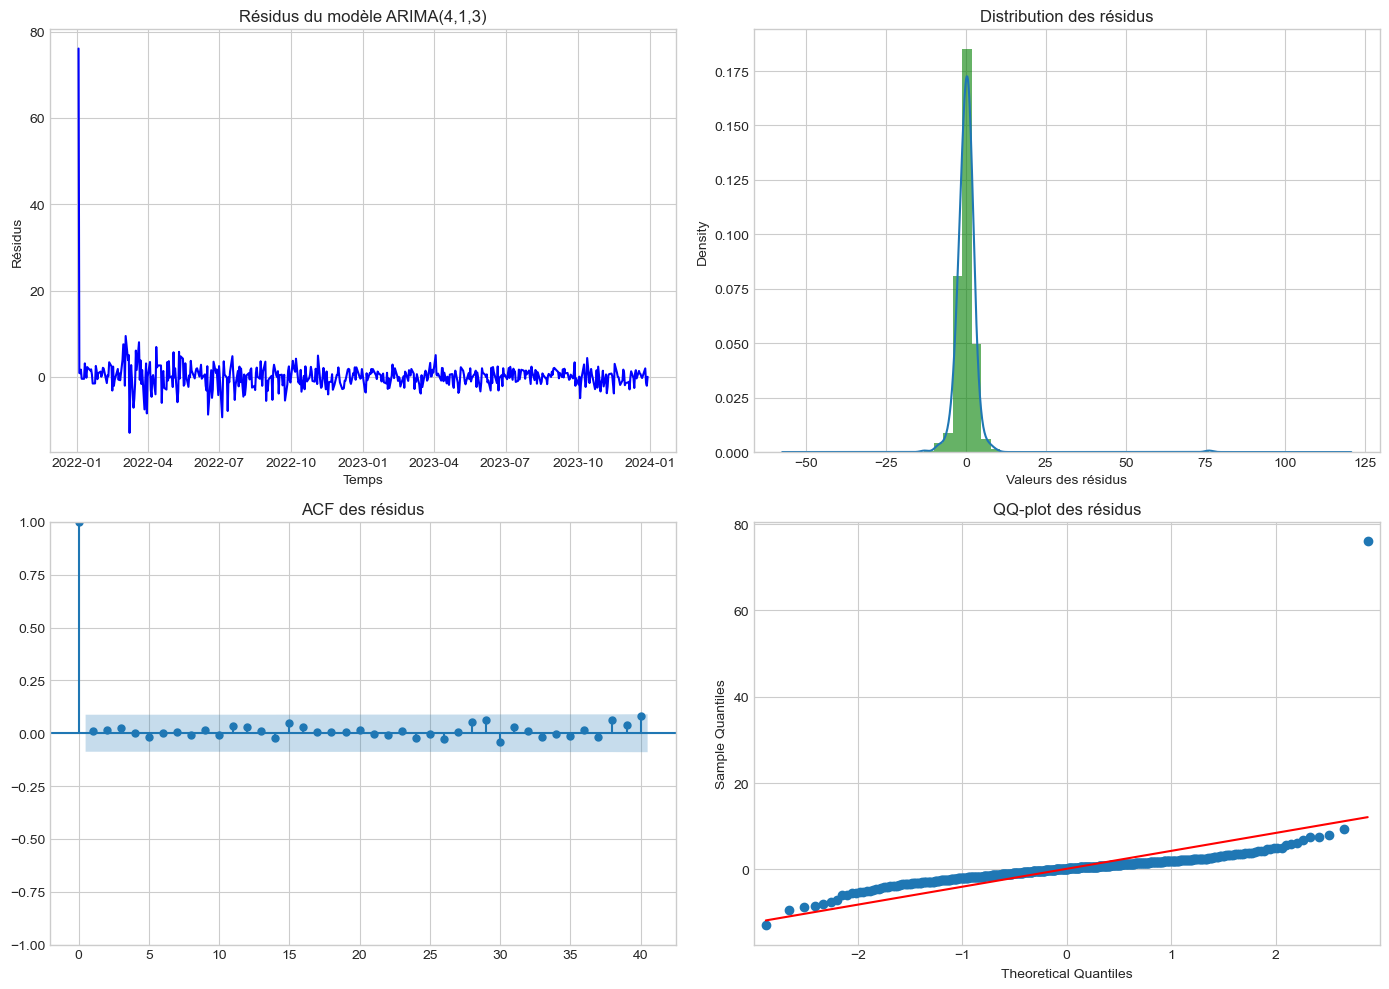

    lb_stat  lb_pvalue
5  0.617035    0.98721


In [ ]:
ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2023-12-31"
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)

close_prices = wti_data['Close'].squeeze().astype(float)

model = ARIMA(close_prices, order=(4, 1, 3))
model_fit = model.fit()

residuals = model_fit.resid

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(residuals, color='blue')
axs[0, 0].set_title("ARIMA(4,1,3) Model Residuals")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Residuals")

residuals.plot(kind='hist', bins=30, density=True, alpha=0.6, color='g', ax=axs[0, 1])
residuals.plot(kind='kde', ax=axs[0, 1])
axs[0, 1].set_title("Residuals Distribution")
axs[0, 1].set_xlabel("Residual Values")

plot_acf(residuals, lags=40, ax=axs[1, 0])
axs[1, 0].set_title("Residuals ACF")

sm.qqplot(residuals, line='s', ax=axs[1, 1])
axs[1, 1].set_title("Residuals Q-Q Plot")

plt.tight_layout()
plt.show()

ljung_box_result = sm.stats.acorr_ljungbox(residuals, lags=[5], return_df=True)
print(ljung_box_result)


# Interpreting the QQ Plot

The QQ plot compares the residuals' distribution against a theoretical normal distribution.

---

## Purpose

- Check if residuals follow a normal distribution.
- Validate assumptions critical for ARIMA model inference.

---

## Visual Interpretation

| Pattern                           | Meaning                               |
|---------------------------------|-------------------------------------|
| Points on the 45° line           | Residuals are normally distributed  |
| S-shaped curve                  | Skewness in residuals                |
| Deviations at tails             | Outliers or heavy tails (kurtosis)  |
| Convex/concave shape            | Residuals more flat or peaked than normal |

---

## Importance

- Normality is key for valid confidence intervals and tests.
- Non-normal residuals may indicate poor model fit or need for data transformation.

When fitting ARIMA models, moving from `d=3` to `d=1` often yielded similar RMSE values, indicating comparable prediction errors. However, similar RMSE does not ensure the models equally capture the data’s dynamics. The differencing order `d` affects stationarity and residual structure. Therefore, it is essential to systematically test residuals—such as with the Ljung-Box test—at each optimization step to confirm the chosen model has no unexplained correlations and is statistically valid.

